In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

np.random.seed(0)


In [7]:

n_samples = 500
n_features = 10       
n_simulations = 1000  
lambda_lasso = 0.1    
                      

n_signal_features = 3  
signal_strength = 5    
std_noise_data = 2     

X_raw = np.random.normal(0, 1, size=(n_samples, n_features))
scaler_X = StandardScaler(with_mean=True, with_std=True) # Center và scale X
X_scaled = scaler_X.fit_transform(X_raw)


def create_data_with_signal_lasso(X_input_scaled, p_features, n_sig_feat, sig_str, std_noise):
    """
    Tạo dữ liệu y có mối quan hệ tuyến tính với một số feature trong X (đã được scale).
    beta_true sẽ được tạo ra sao cho một số hệ số khác 0 và số còn lại bằng 0.
    """
    n_samp = X_input_scaled.shape[0]

    beta_true_slopes = np.zeros(p_features)
    if n_sig_feat > p_features:
        n_sig_feat = p_features

    signal_indices = np.arange(n_sig_feat)
    for i, idx in enumerate(signal_indices):
        beta_true_slopes[idx] = sig_str * ((-1)**i) 

    linear_component = X_input_scaled @ beta_true_slopes
    noise = np.random.normal(0, std_noise, size=n_samp)
    y = linear_component + noise
    return y, beta_true_slopes


def fit_lasso_model(X_data_scaled, y_data, lambda_val):
    """
    Sử dụng sklearn.linear_model.Lasso để fit mô hình.
    """
    model = Lasso(alpha=lambda_val, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X_data_scaled, y_data)
    return model.coef_, model.intercept_


beta_hat_sim_list = [] 
beta_true_slopes_for_plotting = None 

for i in range(n_simulations):
    if i % 100 == 0:
        print(f"Running simulation {i+1}/{n_simulations} for lambda = {lambda_lasso}")


    current_y, current_beta_true_slopes = create_data_with_signal_lasso(
        X_scaled, n_features, n_signal_features, signal_strength, std_noise_data
    )
    
    if i == 0: 
        beta_true_slopes_for_plotting = current_beta_true_slopes

    beta_hat_slopes, intercept_hat = fit_lasso_model(X_scaled, current_y, lambda_lasso)
    
    beta_hat_sim_list.append(np.concatenate([[intercept_hat], beta_hat_slopes]))



Running simulation 1/1000 for lambda = 0.1
Running simulation 101/1000 for lambda = 0.1
Running simulation 201/1000 for lambda = 0.1
Running simulation 301/1000 for lambda = 0.1
Running simulation 401/1000 for lambda = 0.1
Running simulation 501/1000 for lambda = 0.1
Running simulation 601/1000 for lambda = 0.1
Running simulation 701/1000 for lambda = 0.1
Running simulation 801/1000 for lambda = 0.1
Running simulation 901/1000 for lambda = 0.1


In [9]:


columns_beta_hat = ['Intercept'] + [f'Beta_X{j+1}' for j in range(n_features)]
beta_hat_df = pd.DataFrame(beta_hat_sim_list, columns=columns_beta_hat)


beta_true_full_for_plotting = np.concatenate([[0.0], beta_true_slopes_for_plotting])


print(f"\n--- Results for lambda = {lambda_lasso} ---")
print("Trung bình các Beta_hat ước lượng (bao gồm Intercept):")
print(beta_hat_df.mean().round(3))
print("\nBeta_true (Intercept giả định là 0, slopes như đã tạo):")
print(beta_true_full_for_plotting.round(3))


zero_threshold = 1e-5 
num_zeros_lasso = (np.abs(beta_hat_df.iloc[:, 1:]) < zero_threshold).sum() 
print("\nSố lần các hệ số slope được LASSO co về gần 0 (trong tổng số simulations):")
for i in range(n_features):
    is_signal = (i < n_signal_features) 
    true_val = beta_true_slopes_for_plotting[i]
    print(f"  Beta_X{i+1} (true={true_val:.1f}, signal={is_signal}): {num_zeros_lasso[f'Beta_X{i+1}']} times")




--- Results for lambda = 0.1 ---
Trung bình các Beta_hat ước lượng (bao gồm Intercept):
Intercept    0.005
Beta_X1      4.896
Beta_X2     -4.899
Beta_X3      4.904
Beta_X4     -0.001
Beta_X5     -0.003
Beta_X6      0.003
Beta_X7      0.003
Beta_X8      0.002
Beta_X9     -0.003
Beta_X10     0.002
dtype: float64

Beta_true (Intercept giả định là 0, slopes như đã tạo):
[ 0.  5. -5.  5.  0.  0.  0.  0.  0.  0.  0.]

Số lần các hệ số slope được LASSO co về gần 0 (trong tổng số simulations):
  Beta_X1 (true=5.0, signal=True): 0 times
  Beta_X2 (true=-5.0, signal=True): 0 times
  Beta_X3 (true=5.0, signal=True): 0 times
  Beta_X4 (true=0.0, signal=False): 739 times
  Beta_X5 (true=0.0, signal=False): 718 times
  Beta_X6 (true=0.0, signal=False): 747 times
  Beta_X7 (true=0.0, signal=False): 751 times
  Beta_X8 (true=0.0, signal=False): 728 times
  Beta_X9 (true=0.0, signal=False): 736 times
  Beta_X10 (true=0.0, signal=False): 732 times


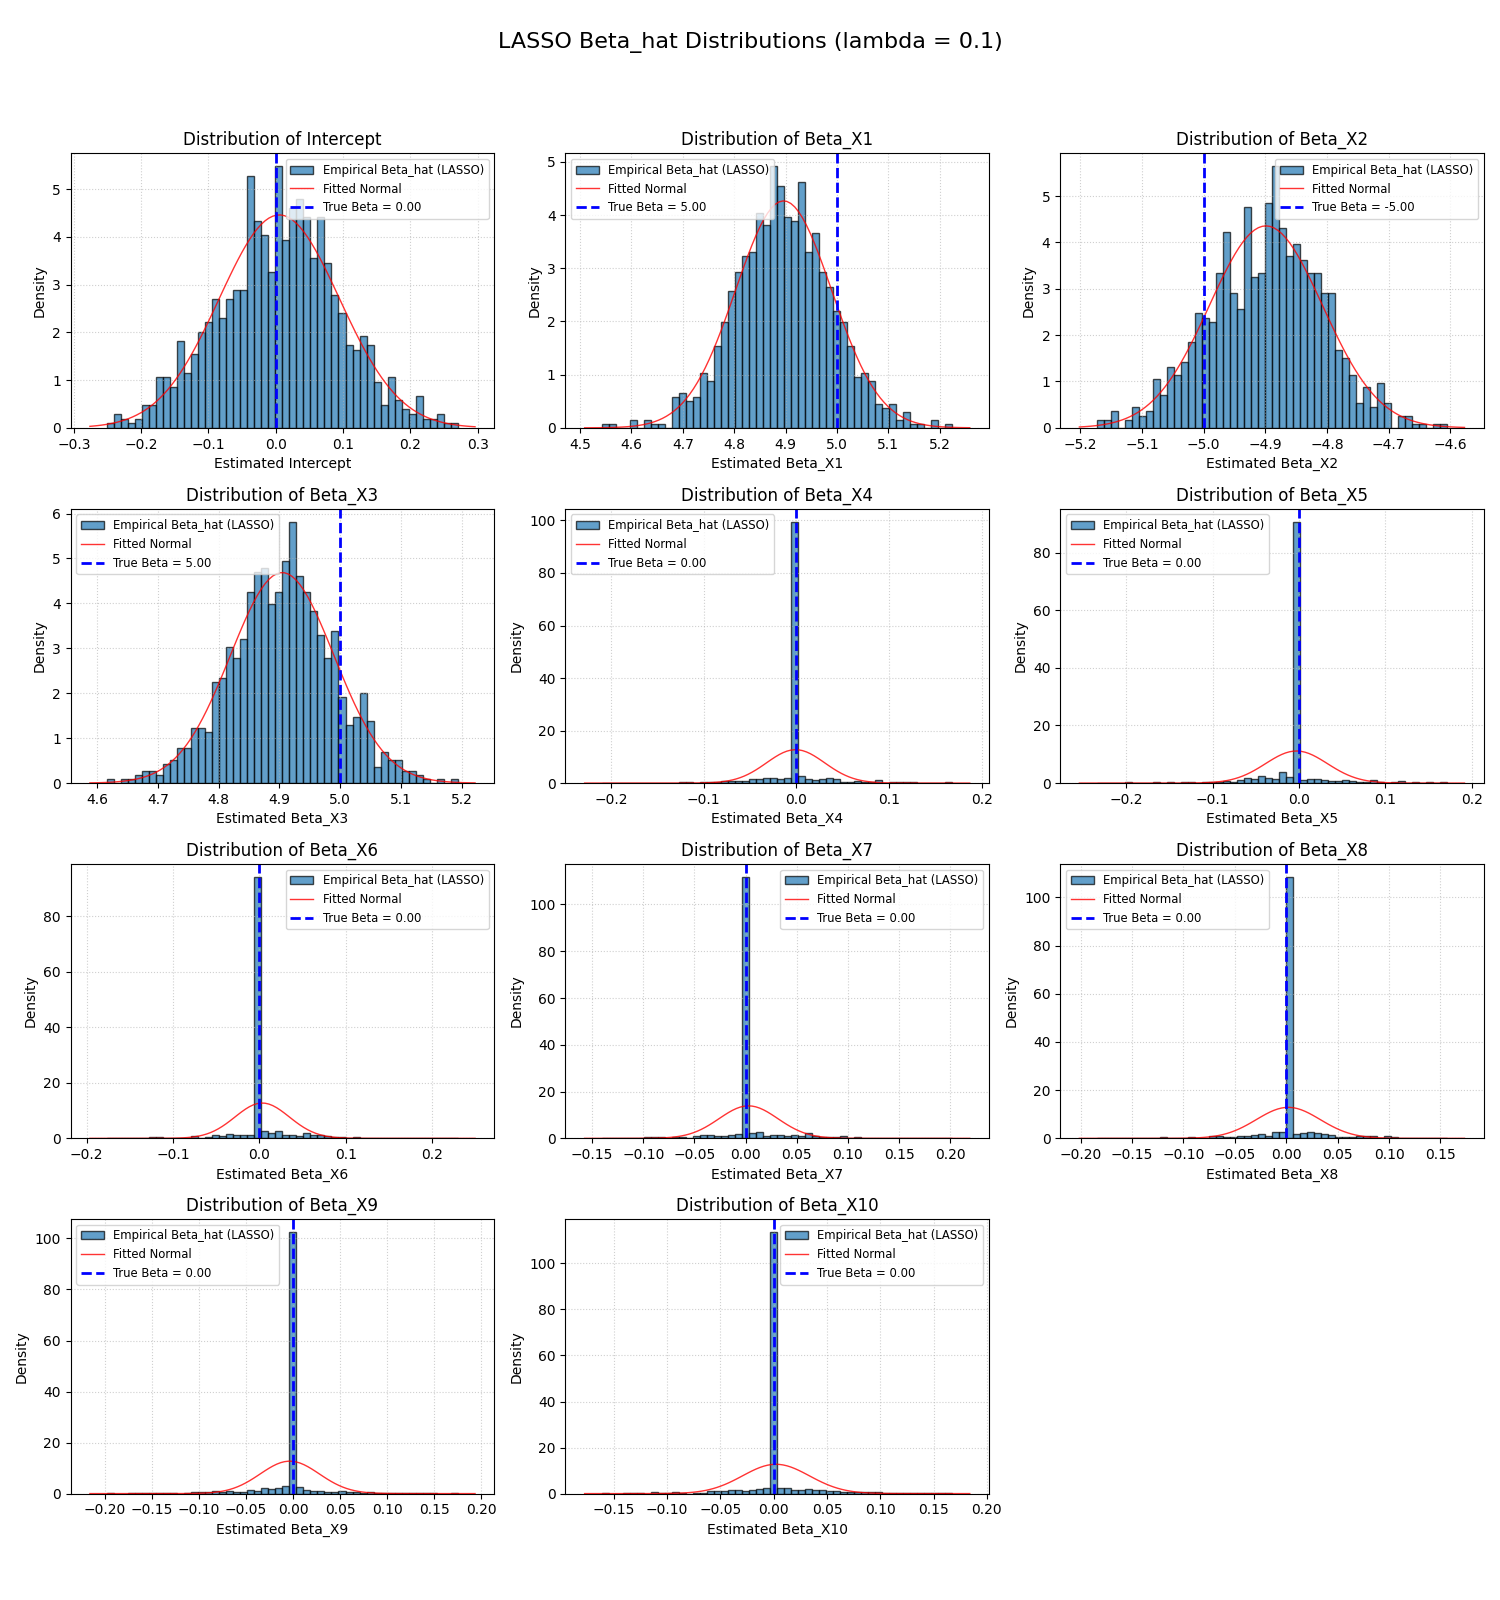

In [10]:

n_cols_plot = 3
n_rows_plot = int(np.ceil((n_features + 1) / n_cols_plot)) 
fig_b, axes_b = plt.subplots(n_rows_plot, n_cols_plot, figsize=(5 * n_cols_plot, 4 * n_rows_plot))
axes_b = axes_b.flatten()

for idx, col_name in enumerate(columns_beta_hat):
    if idx < len(axes_b):
        beta_values_for_hist = beta_hat_df[col_name]
        axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat (LASSO)')
        
        mu_emp, std_emp = norm.fit(beta_values_for_hist)
        xmin_hist, xmax_hist = axes_b[idx].get_xlim()
        x_norm_emp = np.linspace(xmin_hist, xmax_hist, 100)
        p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
        axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=1, alpha=0.8, label=f'Fitted Normal')

        true_val_plot = beta_true_full_for_plotting[idx]
        axes_b[idx].axvline(true_val_plot, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val_plot:.2f}')
        
        axes_b[idx].set_title(f'Distribution of {col_name}')
        axes_b[idx].set_xlabel(f'Estimated {col_name}')
        axes_b[idx].set_ylabel('Density')
        axes_b[idx].legend(fontsize='small')
        axes_b[idx].grid(True, linestyle=':', alpha=0.6)

# Ẩn các subplot không sử dụng
for i in range(len(columns_beta_hat), len(axes_b)):
    fig_b.delaxes(axes_b[i])

fig_b.suptitle(f"LASSO Beta_hat Distributions (lambda = {lambda_lasso})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()